# Lab 6: 随机森林 (Random Forest) -- 分类

### Bootstrap示例

In [1]:
import random

## 生成1到10的整数
numbers = list(range(1,11))
print(numbers)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [2]:
# random.seed(4)
## 在1到10中有放回的抽样10个数字
sample_num = random.choices(numbers, k = 10)
print(sample_num)       # index

[10, 4, 4, 3, 10, 4, 7, 9, 9, 6]


In [3]:
import pandas as pd

## sample_num中独有的数字
pd.unique(sample_num)

array([10,  4,  3,  7,  9,  6])

In [4]:
unum = pd.unique(sample_num)
len(unum)

6

## 导入电信客户流失数据

In [5]:
import os
import sys
import pandas as pd

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from common.filesio import FilesIO
data = pd.read_csv(FilesIO.getLectureData('Telco-Customer-Churn.csv'))
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### TotalCharges 数据类型不对，需转变成数值形式

In [6]:
# Converting Total Charges to a numerical data type.
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')  ## errors='coerce': 无效的值将被设为NaN
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### 去掉含有NaN的行（实例）

In [7]:
# drop missing cases
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [8]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. 设定输出Y和特征X

### 1.1 将输出Y：Churn变成0、1

In [9]:
data['Churn'].replace(to_replace = 'Yes', value = 1, inplace = True)
data['Churn'].replace(to_replace = 'No', value = 0, inplace = True)

y = data.Churn

### 1.2 设定特征X

### 去掉与客户流失关系不大的gender, PhoneService, MultipleLines, TotalCharges与tenure相关性有0.8以上，选择tenure作为特征（tenure与客户流失相关性更大）。

In [10]:
features = ['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']

X = data[features]

In [11]:
X.head()

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,0,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,0,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,0,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,0,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70


### 将网络服务变量中的No internet service类变成No

In [12]:
online_feature = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i, item in enumerate(online_feature):
    X[item].replace(to_replace = 'No internet service', value = 'No', inplace = True) 


C:\Users\NUC\AppData\Local\Temp\ipykernel_13456\3050016260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[item].replace(to_replace = 'No internet service', value = 'No', inplace = True)


In [13]:
X.head()

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,0,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,0,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,0,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,0,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70


In [14]:
X.OnlineSecurity.value_counts()

No     5017
Yes    2015
Name: OnlineSecurity, dtype: int64

### 将分类变量变成虚拟变量

In [15]:
X = pd.get_dummies(X, drop_first = True) ## 将分类变量变成虚拟变量, 丢掉第一类
X.head()

,SeniorCitizen,MonthlyCharges,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,29.85,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,0,56.95,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
2,0,53.85,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3,0,42.30,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0
4,0,70.70,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


## 2. 构建训练集、测试集

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## 3. 随机森林

### 分类问题：使用RandomForestClassifier函数
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

主要参数：
n_estimators: 森林中决策树个数， 默认为100

oob_score :即是否采用袋外样本来评估模型的好坏

criterion: 即CART树做划分时对特征的评价标准。分类随机森林对应的CART分类树默认是基尼系数gini,另一个可选择的标准是信息增益

max_features: 结点划分时考虑的最大特征数。默认为sqrt(p)。可选值：{“sqrt”, “log2”, None}, 整数 or 浮点数
如果是整数（int），则在每次分裂时考虑最大特征数（max_features）个特征。
如果是浮点数（float），则max_features是一个分数，每次分裂时会考虑max(1, int(max_features * n_features_in_))个特征。
如果是"sqrt"，则max_features=sqrt(n_features)。
如果是"log2"，则max_features=log2(n_features)。
如果是None，则max_features=n_features。



max_depth:决策树最大深度

min_samples_split: 内部节点再划分所需最小样本数， 默认为2

min_samples_leaf: 叶子节点最少样本数， 默认为1

max_leaf_nodes:最大叶子节点数

ccp_alpha: 后剪枝调整参数

class_weight：输出Y的类的权值。可选取值 “balanced”, “balanced_subsample”。默认为None，即每个类的权值都为1. 如果为“balanced”，每类的权值为总实例数/该类实例数。

### 3.1 加载随机森林模型

In [17]:
from sklearn.ensemble import RandomForestClassifier

## 定义随机森林分类模型
model_rf = RandomForestClassifier(n_estimators=100 , oob_score = True, 
                                  random_state =50, max_features = "sqrt")


### 3.2 在训练集上训练模型

In [18]:
## 在训练集上训练模型
model_rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=50)

### 袋外分类正确率（OOB）

In [19]:
model_rf.oob_score_

0.7373909745923398

### 3.3 特征重要性

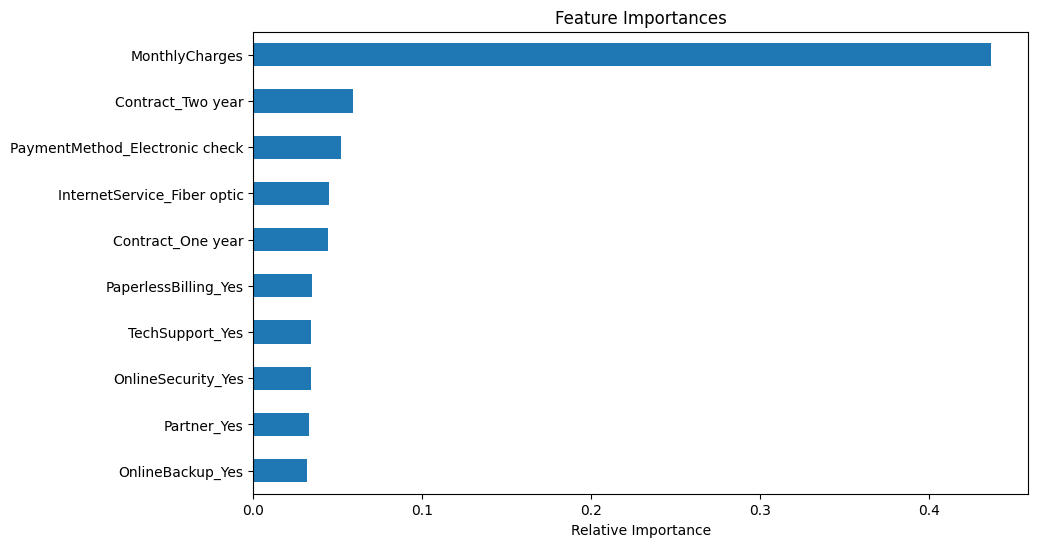

In [20]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

In [21]:
weights.sort_values(ascending = False) ## 从大到小排序重要性

MonthlyCharges                           0.437108
Contract_Two year                        0.058863
PaymentMethod_Electronic check           0.051960
InternetService_Fiber optic              0.044640
Contract_One year                        0.044410
PaperlessBilling_Yes                     0.034787
TechSupport_Yes                          0.033968
OnlineSecurity_Yes                       0.033963
Partner_Yes                              0.033293
OnlineBackup_Yes                         0.032077
DeviceProtection_Yes                     0.030966
Dependents_Yes                           0.029679
SeniorCitizen                            0.029430
StreamingMovies_Yes                      0.027180
StreamingTV_Yes                          0.025735
PaymentMethod_Credit card (automatic)    0.019711
PaymentMethod_Mailed check               0.016918
InternetService_No                       0.015313
dtype: float64

### 3.4 在测试集上做预测

### 预测类别： 用predict

In [22]:
# 在测试集上做预测
y_pred = model_rf.predict(X_test)

y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

### 预测类别的概率：用predict_proba

In [23]:
y_pred_prob = model_rf.predict_proba(X_test)
y_pred_prob

array([[0.97166667, 0.02833333],
       [0.95      , 0.05      ],
       [0.87      , 0.13      ],
       ...,
       [0.37      , 0.63      ],
       [0.84      , 0.16      ],
       [1.        , 0.        ]])

## 4. 评价模型

### 4.1 分类正确率

In [24]:
test_accuracy = model_rf.score(X_test, y_test)
print("Accuracy", test_accuracy)

Accuracy 0.7622298065984073


### 4.2 精确率 (precision), 召回率 (recall), F1值

In [25]:
from sklearn import metrics
test_precision = metrics.precision_score(y_test, y_pred)
print("Precision", test_precision)

test_recall = metrics.recall_score(y_test, y_pred)
print("Recall:", test_recall)

test_f1 = metrics.f1_score(y_test, y_pred)
print("test_f1:", test_f1)

Precision 0.5390835579514824
Recall: 0.44742729306487694
test_f1: 0.4889975550122249


### 4.3 混淆矩阵

In [26]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1140,  171],
       [ 247,  200]], dtype=int64)

Text(0.5, 1.0, 'Accuracy Score: 0.7622298065984073')

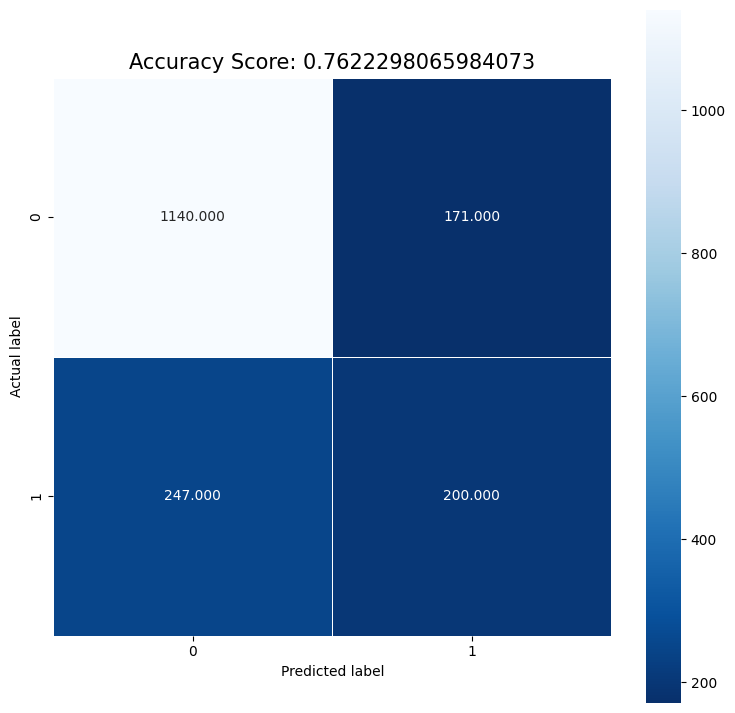

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cnf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy)
plt.title(all_sample_title, size = 15)

### 4.4 ROC和AUC

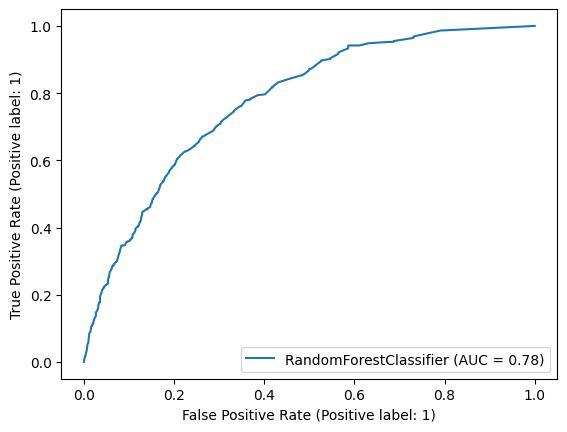

In [28]:
metrics.RocCurveDisplay.from_estimator(model_rf, X_test, y_test) 
plt.show()

## Q:  如何对随机森林进行调参？

使用网格搜索法GridSearchCV

sklearn.model_selection.GridSearchCV(estimator, param_grid, , scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2n_jobs', error_score=nan, return_train_score=False)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimator: 代表使用的模型 param_grid: 需要最优化的参数的取值，值为字典或者列表。需要给出参数名以及参数的可能取值 scoring: 模型评价指标。在分类问题中，常见的为'accuracy','f1'(两分类),'f1_micro','f1_macro',"roc_auc"(两分类)等，更多见下方链接。 https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

cv: 交叉验证次数

可以考虑的参数： n_estimators，max_depth, max_features，min_samples_leaf，ccp_alpha等

## Q：如何用随机森林解决回归问题？

使用函数 RandomForestRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

主要参数：
n_estimators: 森林中决策树个数， 默认为100

oob_score :即是否采用袋外样本来评估模型的好坏

criterion: 即CART树做划分时对特征的评价标准。回归树默认指标为平方误差

max_features: 结点划分时考虑的最大特征数。默认为1

max_depth:决策树最大深度

min_samples_split: 内部节点再划分所需最小样本数， 默认为2

min_samples_leaf: 叶子节点最少样本数， 默认为1

max_leaf_nodes:最大叶子节点数

## Q：如何处理不平衡数据（Y的每类实例数很不一样）

常用方法：

1. 类加权。使用class_weight="balanced", 逻辑回归、分类树、随机森林等函数中都有class_weight选项

2. 重采样。包括两种方法：

(1) 欠采样，将数量多类别（记为majority）的样本进行抽样，使之数量与数量少的类别（minority）的数量相当，以此达到数量的平衡。

(2) 过采样，将数量少的类别（minority）的样本进行复制，使之数量与数量多的类别(majortity)的数量相当，以此达到数量的平衡。由于复制了多份minority样本，过采样会改变minority方差。


可参考
https://www.jb51.net/article/203417.htm

经典算法：SMOTE (Synthetic Minority Over-sampling Technique)基于minority样本相似的特征空间构造新的人工样本。(注意：只对训练集进行SMOTE！) 步骤如下：

选择一个minority样本，计算其KNN邻居

在K个邻居中，随机选择一个近邻

修改某一个特征,偏移一定的大小：偏移的大小为该minority样本与该近邻差距乘以一个小的随机比率(0, 1)， 就此生成新样本

In [29]:
from sklearn.model_selection import GridSearchCV